In [2]:
# # Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input/sf-dl-car-classification'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print('\nОбогащенные данные') 
for dirname, _, filenames in os.walk('../input/filtered-data-with-new-images'):
    print(dirname)

In [1]:
#  imports
import sys, os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL
from sklearn.metrics import f1_score, accuracy_score
from PIL import Image

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Accuracy , Precision
from tensorflow.keras.activations import *
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, LeakyReLU

from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib  # для проверки подключения GPU

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

In [2]:
sample_submission_path = '/kaggle/input/sf-dl-car-classification/sample-submission.csv'

# пути до обогащенных данных
train_path = '../input/filtered-data-with-new-images/train/train'
sub_path = '../input/filtered-data-with-new-images/test/test_upload'

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Проверка доступности GPU

In [4]:
!nvidia-smi

In [5]:
def check_GPU_ON():
    d_list_devices = device_lib.list_local_devices()
    d_list_devices_GPU = [x.name for x in d_list_devices if 'GPU' in x.name]
    print ('GPU подключен') if d_list_devices_GPU else  print('!WARNING! GPU не подключен')
    return

print(f"TensorFlow version with cuda: {tf.test.is_built_with_cuda()}")
# check_GPU_ON()



## Первичный анализ данных

In [5]:
train_df = pd.read_csv('../input/sf-dl-car-classification/train.csv')

train_df.head()

In [7]:
# посмотрим на сбалансированность классов
train_df.Category.value_counts().plot(kind='bar')

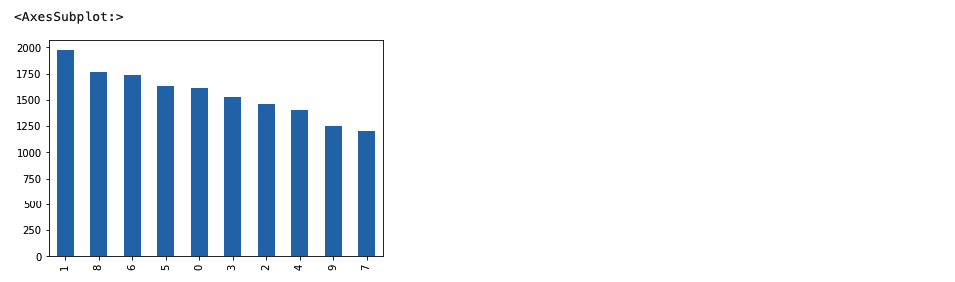

In [8]:
# Подсчитаем в кол-ном выражении разницу среди классов
max_count = train_df.Category.value_counts().max()
np.abs(train_df.Category.value_counts() - max_count)

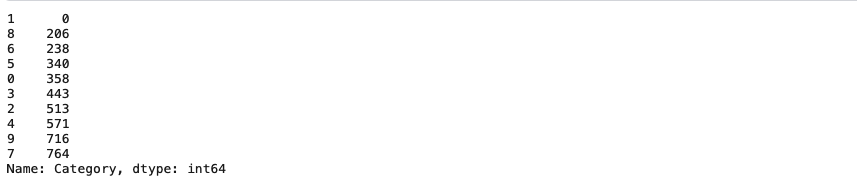

Таким образом, забегая вперед, скажу, что в сравнении с классом 0, классы 2, 4, 9 и 7 имеют значительно меньше экземпляров своего класса для обучения классификатора, что может привести в большей ошибки классификации на тестовых изображениях.  
Так же визуальный анализ самих тренировочных изображений позволил очистить каждый класс от ошибных изображений, которые не относятся к данному классу.  
После ручного анализа и удаления фото с изображениями, либо совсем иной модели авто, либо с очень маленьким разрешением ( не более 190 по одной из осей), удалено было порядка 150 изображений.  
Приведу несколько примеров удаленных изображений:  
- из класса 9 ( ВАЗ 21099) удалены: машина с кастомным капотом другой формы, десятка, восьмерка  
- из класса 8 (Passat Volkswagen) удалены: авто другой марки, битая машина, фото очень низкого разнешения  
- из класса 7 (ВАЗ 2109) удалены: старый Volkswagen Passat , Cherry Amulet, старая Audi, авто марки ИЖ и........ фото грузовика ЗИЛ  

При этом хорошие изображения, которые оказались ошибочно размещены в не верных классах, а так же класс которых имеется в данном проекте я добавил к другим фото актуального класса.  Так сказать переиспользовал часть изображений.  


### Обогащение данных

Ввиду того, что в первой версии ноутбука ( на предоставленных данных) меня не устроила получаемая точность (результат на лидерборде 0.94576), решено было дополнительно обогатить данные новыми фотографиями с портала drom.ru. Тем самым я преследовал цель улучшить метрику ввиду того, что модель будет обучаться на большем кол-ве данных, а так же устранить не сбалансированность классов, которая была выявлены в ходе предварительного анализа в начале ноутбука.  
Сбор дополнительных изображений данных не автоматизировал, так как не все изображения, размещаемые в объявлении по продаже авто подходят к данному соревнованию.  Например, фото моторного отсека, салона, внутреннего убранства багажника или днища авто абсолютно не нужны.  В тестовом и тренировочном наборах данных присутсвуют только изображния, снятые общим планом с разных сторон и ракурсов снаружи, преимущественно без наличия в кадре других машин. Поэтому было важно обогатить данные фотографиями аналичного содержания.   
Суммарно по всем классам удалось собрать 4468 изображений.
Датасет, содержащий изначальные изображения и собранные мной, загружен в директории `filtered-data-with-new-images`.

### Анализ обогащенных данных

In [9]:
# # создадим датафрейм с названием файла и класса изображенного на фото авто
# # df_list = [] # соберем получаемые датафреймы каждого класса для последующей конкатенации
# data_list = [] # список списков данных по каждому объекту [путь, категория, имя_файла (Id), width, height]
# TRAIN_ROOT = '../input/filtered-data-with-new-images/train/train'

# for dirname, _, filenames in os.walk(TRAIN_ROOT):
#     if len(filenames) == 0:
#         continue
    
#     current_category = dirname.split('/')[-1]
#     # print(dirname, '==>', len(filenames))
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#     for filename in filenames:
#         img_path = os.path.join(dirname, filename)
#         img_size = Image.open(img_path).size
#         w, h = Image.open(img_path).size  # width and height of image
#         data_list.append([img_path, current_category, filename, w, h])
        
# train_df = pd.DataFrame(np.array(data_list), columns=['path', 'category', 'Id', 'width', 'height'])

Прочтем загруженный заново датафрейм train

In [3]:
#  прочтем загруженный датафрейм с новыми данными
train_df = pd.read_csv('../input/filtered-data-with-new-images/train_data_with_new_images.csv', index_col=0)
train_df.head()

In [8]:
train_df.info()

In [9]:
# посмотрим на сбалансированность классов в новом датасете
train_df.category.value_counts().plot(kind='bar')

Отлично. Теперь классы сбалансированны

Посмотрим выборочно на изображения

In [8]:
print('Пример картинок (random sample)')
plt.figure(figsize=(20,12))

random_image = train_df.sample(n=16)
random_image_paths = random_image['path'].values
random_image_cat = random_image['category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(path)
    plt.subplot(4,4, index+1)
    plt.imshow(im)
    plt.title('Class: '+ str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Узнаем сколько датасет имеет изображений с низким разрешением, например менее 300 точек на сторону

In [10]:
# Посмотрим какое кол-во изображений по каждому классу имеет разрешение ниже чем 240

# для этого сначала переведем значения признаков width и height к типу данный int16
train_df['width'] = train_df['width'].astype('int16')
train_df['height'] = train_df['height'].astype('int16')
# train_df['Category'] = train_df['Category'].astype('object')
border_val = 240

lower_df_grouped = train_df.loc[(train_df.width < border_val) | (train_df.height < border_val)].groupby('category').agg({'path': ['count']})
print(f"Total small images quantity: {lower_df_grouped['path']['count'].sum()} items")
display(lower_df_grouped)

Кол-во изображений с низким разрешением ничтожно мало и на это можно не обращать снимания.

Для ускорения последующей разработки сохраним полученный датафрейм


In [14]:
# ячейку необходимо выполнить лишь однажды, для сохранения датафрейма с обогащенными данными
# train_df.to_csv('train_data_with_new_images.csv')  

### MAIN MODEL SETTINGS

In [15]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS = 10
BATCH_SIZE = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
PATIENCE = 5 # for early stopping callback function
LR = 1e-3
VAL_SPLIT = 0.10
CLASS_NUM = 10
IMG_SIZE = 224  # 320
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


RANDOM_SEED = 37
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

#### Usefull functions

In [16]:
# coffe break function - delete after debug
def coffe_break():
    cur_time = 0
    while True:
        print(f"time: {cur_time} min")
        cur_time += 1
        time.sleep(60)


def show_first_images(generator, count=9, labels=True, figsize=(30, 12), normalized=False):
  generator = itertools.islice(generator, count)
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # - изображение в формате uint8, яркость от 0 до 255
    # - изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

    
# new plot function from https://www.kaggle.com/code/nesquik/car-classification
def plot_history(history, metric=''):
    """
    Функция для вывода графиков обучения
    Аргументы:
        history - история обучения, полученная из метода fit модели keras
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    if metric:
        axes[0].plot(history.history[metric])
        axes[0].plot(history.history[f"val_{metric}"])
        axes[0].set_title(f"Model {metric}")
        axes[0].set_ylabel(f"{metric}")
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Test'])

    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'])
    
    axes[2].plot(history.history['lr'])
    axes[2].set_title('Model lr')
    axes[2].set_ylabel('lr')
    axes[2].set_xlabel('Epoch')
    axes[2].legend(['lr'])
    plt.show()


#### Аугментация данных

In [17]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [18]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [19]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        #rescale=1./255,  # для EfficientNetB6 нормализация делается под "капотом модели"
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
sub_datagen = ImageDataAugmentor(
    # rescale=1./255,  # для EfficientNetB6 нормализация делается под "капотом модели"
)

**Создаем генераторы изображений**

In [21]:
# DATA GENERATION
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'training'
)


val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'validation'
)


### MODEL - Transfer learning

#### STEP 1: обученная модель EfficientNetB6 с weights='imagenet', с кастомной головой и полной заморозкой весов базовой модели.

In [22]:
#EfficientNetB6 + new head with batchnorm
base_model = efficientnet.EfficientNetB6(weights='imagenet',
                                         include_top=False,
                                         input_shape=INPUT_SHAPE)

# freeze base layers
base_model.trainable = False

model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(512, activation=None, kernel_initializer=initializers.GlorotNormal()),
                    BatchNormalization(),
                    LeakyReLU(0.2),
                    Dropout(0.3),
                    Dense(CLASS_NUM, activation='softmax')])

model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate=LR),
              metrics = ["accuracy"],
             )

In [23]:
model.summary()

In [24]:
# сколько слоев
print(len(model.layers))

# сколько тренируемых слоев
print(len(model.trainable_variables))

In [25]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [26]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor = 'val_accuracy',
                             verbose = 1,
                             mode = 'max',
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = PATIENCE,
                          verbose = 1,
                          restore_best_weights = True)


def lr_exp_decay(epoch, lr):
    k = 0.5
    return LR * np.exp(-k*epoch)


lr_rate_scheduler = LearningRateScheduler(lr_exp_decay,
                                          verbose=1)

callbacks_list = [checkpoint, earlystop, lr_rate_scheduler]

In [27]:
%%time
scores = model.evaluate(val_generator, steps=len(val_generator), verbose = 1)
print('Accuracy: %.2f%%' % (scores[1]*100))

In [28]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = EPOCHS,
                    workers = 4,
                    callbacks = callbacks_list,
                   )

In [29]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print('Accuracy: %.2f%%' % (scores[1]*100))

In [30]:
# сохраним итоговую сеть и подгрузим веса лучшей итерации в обучении (best_model)
model.save('model_efn_b6_step_1.hdf5')
model.load_weights('./best_model.hdf5')

In [32]:
plot_history(history, metric='accuracy')

## STEP 2 - FineTuning - обучение половины весов

In [34]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# сначала разморозим все слои
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

print(f"Кол-во тренируемых слоев в base_model: {len(base_model.trainable_variables)}")


In [35]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [36]:
# Изменим некоторые константы
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Устанавливаем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 37
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [37]:
# DATA GENERATION
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'training'
)


val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'validation'
)

In [38]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=LR),
              metrics = ["accuracy"],
             )

In [39]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor = 'val_accuracy',
                             verbose = 1,
                             mode = 'max',
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = PATIENCE,
                          verbose = 1,
                          restore_best_weights = True)


def lr_exp_decay(epoch, lr):
    k = 0.5
    return LR * np.exp(-k*epoch)


lr_rate_scheduler = LearningRateScheduler(lr_exp_decay,
                                          verbose=1)

callbacks_list = [checkpoint, earlystop, lr_rate_scheduler]

In [41]:
model.summary()

In [42]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = EPOCHS,
                    workers = 4,
                    callbacks = callbacks_list,
                   )

In [43]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose = 1)
print('Accuracy: %.2f%%' % (scores[1]*100))

In [44]:
model.save('model_efn_b6_step_2.hdf5')
model.load_weights('best_model.hdf5')

In [45]:
plot_history(history, metric='accuracy')

## STEP 3 - FineTuning - разморозка всей сети BASE MODEL

In [46]:
# Если выполняем шаг 3 без перезагрузки ноутбука
# разморозим все слои
base_model.trainable = True

print(f"Кол-во тренируемых слоев в base_model: {len(base_model.trainable_variables)}")


In [47]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# Устанавливаем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 37
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0


In [48]:
# DATA GENERATION
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'training'
)


val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED,
    subset = 'validation'
)

In [49]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adam(learning_rate=LR),
              metrics = ["accuracy"],
             )

In [50]:
model.summary()

In [51]:
checkpoint = ModelCheckpoint('best_model.hdf5',
                             monitor = 'val_accuracy',
                             verbose = 1,
                             mode = 'max',
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = PATIENCE,
                          verbose = 1,
                          restore_best_weights = True)


def lr_exp_decay(epoch, lr):
    k = 0.5
    return LR * np.exp(-k*epoch)


lr_rate_scheduler = LearningRateScheduler(lr_exp_decay,
                                          verbose=1)

callbacks_list = [checkpoint, earlystop, lr_rate_scheduler]

In [52]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = EPOCHS,
                    workers = 4,
                    callbacks = callbacks_list,
                   )


In [53]:
model.save('model_efn_b6_step_3.hdf5')
model.load_weights('best_model.hdf5')

In [54]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose = 1)
print('Accuracy: %.2f%%' % (scores[1]*100))

In [55]:
plot_history(history, metric='accuracy')

## Step 4 - Дообучение модели на увеличенном размере изображения (Extra Fit) и пониженном уровне аугментации

In [56]:
IMG_SIZE             = 512
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30,
                          interpolation=1,
                          border_mode=4,
                          value=None,
                          mask_value=None,
                          always_apply=False,
                          p=0.5)
])

train_datagen = ImageDataAugmentor(
        # rescale=1./255,  # для EfficientNetB6 нормализация делается под "капотом модели"
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
sub_datagen = ImageDataAugmentor(
    # rescale=1./255,  # для EfficientNetB6 нормализация делается под "капотом модели"
)


In [57]:
# DATA GENERATION
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size = (IMG_SIZE, IMG_SIZE),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = RANDOM_SEED,
                                                    subset = 'training',
                                                    )

val_generator = train_datagen.flow_from_directory(train_path,
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  seed = RANDOM_SEED,
                                                  subset = 'validation',
                                                  )
                                                    


Создадим сеть заново с новым размером входных данных

In [58]:
base_model = efficientnet.EfficientNetB6(weights = 'imagenet',
                                         include_top = False,
                                         input_shape = INPUT_SHAPE)

In [59]:
EPOCHS               = 4  # эпох на обучение
LR                   = 1e-5

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

model.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса

callbacks_list = [checkpoint, earlystop, lr_rate_scheduler]

In [60]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = val_generator, 
                    validation_steps = val_generator.samples//val_generator.batch_size,
                    epochs = EPOCHS,
                    workers = 4,
                    callbacks = callbacks_list,
                   )

In [61]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [63]:
scores = model.evaluate_generator(val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [64]:
plot_history(history, metric='accuracy')

## Предсказание на тестовых данных

In [65]:
test_sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe = pd.read_csv(sample_submission_path),
    directory = sub_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [66]:
test_sub_generator.samples

In [67]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [68]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

In [69]:
submission.head()

Результат на лидерборде: score = 0.97138  
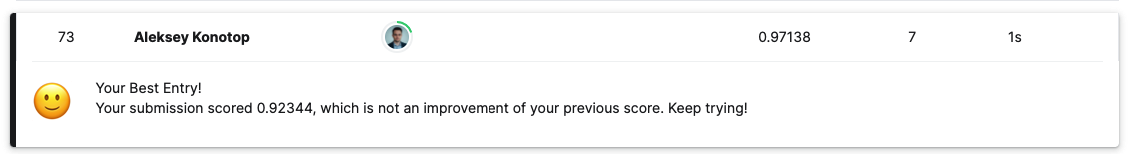

## TTA - Test Time Augmentation

In [ ]:
# load last model
model.load_weights('best_model.hdf5')

In [70]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [71]:
test_datagen = ImageDataAugmentor( 
    # rescale=1./255,  # для EfficientNetB6 нормализация делается под "капотом модели"
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = pd.read_csv(sample_submission_path),
    directory = sub_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

In [72]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

In [73]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [75]:
filenames_with_dir = test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Результат на лидерборде стал значительно хуже: score = 0.92344

### ВЫВОДЫ

В рамках данной работы был достигнут score на лидерборде равный 0.97138.  
На момент завершения проекта данный результат занял 73 место среди всех участников соревнования.  
В первой ноутбука, без сбора дополнительных данных, был достигнут score = 0.94576. С целью улучшения метрики можно было использовать различные приемы, например ансамблирование моделей, изменение архитектуры модели, использование подхода под названием TTA (Test Time Augmentation), обогащение тренировочных данных путем сбора новых фотографий автомобилей используемых в соревновании моделей.  
Опытным путем была подобрана архитектура модели, указанная ниже. В общей сложности были протестированы несколько типов архитектур на основе efficientnetb6 модели с разными планировщиками lerning rate и других callback-функций. Метрикой качества потенциальной архитектуры был максимальный score после обучения на 15 эпох модели с полностью замороженной базовой моделью.


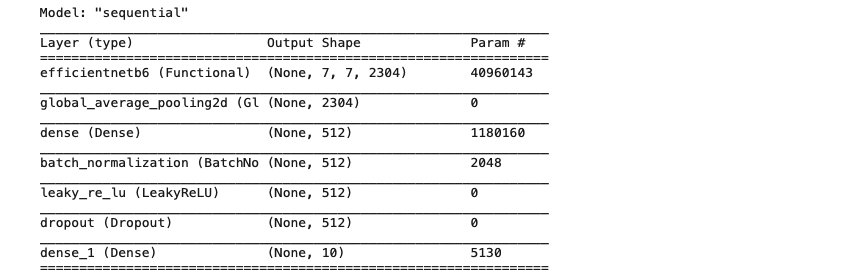

С помощью confusion matrix удалось определить в каких классах модель ошибается чаще. После проведения визуального анализа изображений для тренировки, были удалены изображения, которые никак на связанны с классом, в котором они находились. Это так же, в очередной раз, подтверждает принцип "Garbage in - garbage out."  
Обогащение новыми данными, позволило устранить не сбаланнсированность классов в тренировочных данных.  В общей сложности, на сбор и фильтрацию изображений ушло несколько дней плотной работы.  
  
На практике, опробована библиотека для аугментации данных albumentations, которая, как утверждают в рамках учебной программы, более эффективна, чем встроенный класс ImageDataGenerator из библиотеки tf.keras.preprocessing.image.  
Весь комплекс мер позволил улучшить результат на лидерборде с 0.94576 до 0.97138. При этом использование подхода TTA привело, наоборот, к падению качества модели до 0.92344. Видимо, в конкретно данной задаче, использование TTA не целесообразно.  
Что было протестированно в рамках проекта:  
- transfer learning и fine-tuning
- настройка LR
- подобраны переменные (размер картинки, батч и т.д.)
- использована SOTA архитектура сети EfficientNet-B6
- различные конфигурации архитектуры головы моделим
- применены дополнительные функции callback для модели:
    - ModelCheckpoint,
    - EarlyStopping,
    - ReduceLROnPlateau,
    - LearningRateScheduler
- TTA (Test Time Augmentation)  

В рамках работы над проектом был получен положительный опыт в работе с нейронными сетями в задаче классификации изображений.

Что не успел реализовать в рамках проекта:
- Обернуть модель в сервис на Flask,  
- Ансамблирование нескольких моделей

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)